# WhatsApp Chat Exploration and Feature Extraction

## Purpose
The purpose of this notebook is to play with using SVD (singular value decomposition) and other techniques to try and extract location and named entities from HERO Group Chat messages.

In [3]:
import re
import datetime
from dateutil.parser import parse

import numpy as np
import pandas as pd
import seaborn as sns

## Parsing

In [4]:
pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', -1)  # or 199

In [5]:
f=open("WhatsApp Chat with HERO MEMBER GROUP #22.txt", "r")

In [6]:
contents = f.read()
f.close()

In [7]:
contents[:500]

'10/29/19, 4:49 PM - Messages to this group are now secured with end-to-end encryption. Tap for more info.\n10/29/19, 3:21 PM - Stacy Emergency Services created group "HERO MEMBER GROUP #22"\n10/29/19, 4:49 PM - You joined using this group\'s invite link\n10/29/19, 4:49 PM - +509 36 50 0000 joined using this group\'s invite link\n10/29/19, 4:49 PM - +509 48 45 8822 joined using this group\'s invite link\n10/29/19, 4:49 PM - +509 48 91 1213 joined using this group\'s invite link\n10/29/19, 4:49 PM - +509 34'

https://regex101.com/r/2gs5Fn/1

In [8]:
def parse_whatsapp_export(contents):
    """ Parse contents of WhatsApp Exported Text File """
    
    regex = re.compile(r'([0-9]{1,2}\/[0-9]{1,2}\/[0-9]{2},\s[0-9]{1,2}:[0-9]{2}\s(PM|AM))\s-\s([+()\-\s\d\w]+)(:\s<Media omitted>|:|joined|created|edited|updated)')
    messages = re.split(regex, contents)
    
    # First message is just notice of encryption...
    # TODO - fix to account for messages like this permanently
    messages = messages[1:]
    
    data = []
    for i in range(0, len(messages), 5):
        datetimestring = messages[i+0]
#         datetime = datetime.strptime(datestring, '%m/%d/%y, %H:%M %p')
        source = messages[i+2]
        category = messages[i+3]
        content = messages[i+4]
        data.append([datetimestring, source, category, content])
    
    return np.array(data)

In [9]:
data = parse_whatsapp_export(contents)

In [10]:
data.shape

(640, 4)

In [11]:
df = pd.DataFrame(data, columns=['datetime', 'source', 'category', 'content'])

In [12]:
df.sample(10)

,datetime,source,category,content
362,"11/12/19, 8:11 AM",Amandine,:,12/11/19 8:10. Jets de pierres rapportés zone...
623,"12/20/19, 8:11 PM",Stacy Emergency Services,:,Heavy traffic at freres at Djumbala. Violent ...
545,"11/25/19, 12:28 PM",Sarah Layton,:,25.11.2019 | 12:19 Barricade érigé avec 1 co...
531,"11/24/19, 2:15 PM",Stacy Emergency Services,:,14:15 \nCarrefour Aeroport/Viaduct/Overpass:\...
54,"10/29/19, 5:21 PM",+509 37 43 3801,joined,using this group's invite link\n
86,"10/29/19, 7:01 PM",+509 34 55 0277,joined,using this group's invite link\n
459,"11/18/19, 9:40 AM",Sarah Layton,:,18.11.2019 | 09:25 minutes\nBarricades consta...
305,"11/7/19, 10:37 AM",Sarah Layton,:,Correction: Champs de Mars. Not in Jacmel\n
593,"12/6/19, 1:50 PM",Stacy Emergency Services,:,"Rocks thrown, and Molotov cocktails reported ..."
26,"10/29/19, 4:52 PM",+509 37 01 6217,: <Media omitted>,\n


## Data Cleanup

In [13]:
df_clean = df.copy()
df_clean.head()

,datetime,source,category,content
0,"10/29/19, 3:21 PM",Stacy Emergency Services,created,"group ""HERO MEMBER GROUP #22""\n"
1,"10/29/19, 4:49 PM",You,joined,using this group's invite link\n
2,"10/29/19, 4:49 PM",+509 36 50 0000,joined,using this group's invite link\n
3,"10/29/19, 4:49 PM",+509 48 45 8822,joined,using this group's invite link\n
4,"10/29/19, 4:49 PM",+509 48 91 1213,joined,using this group's invite link\n


In [14]:
df_clean.category.unique()

array(['created', 'joined', ':', ': <Media omitted>'], dtype=object)

In [15]:
df_clean.replace({'category': r':\s<Media omitted>$'}, {'category': 'media'}, regex=True, inplace=True)
df_clean.replace({'category': r':$'}, {'category': 'report'}, regex=True, inplace=True)

In [16]:
df_clean.category.unique()

array(['created', 'joined', 'report', 'media'], dtype=object)

In [17]:
df_clean.columns

Index(['datetime', 'source', 'category', 'content'], dtype='object')

In [18]:
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

In [19]:
df_clean.dtypes

datetime    datetime64[ns]
source              object
category            object
content             object
dtype: object

In [20]:
s_mo = df_clean['datetime'].apply(lambda x: x.month)
s_yr = df_clean['datetime'].apply(lambda x: x.year)

In [21]:
# Add columns for months and years
df_clean['month'] = s_mo
df_clean['year'] = s_yr

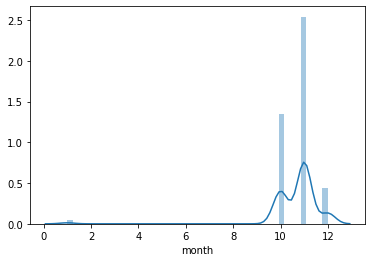

In [22]:
sns.distplot(df_clean['month'])

In [1]:
# Save cleaned data
df_clean.to_pickle('whatsapp_dataframe.pkl')

NameError: name 'df_clean' is not defined

## Re-entry Point

In [4]:
# Load cleaned data
df_clean = pd.read_pickle('whatsapp_dataframe.pkl')

## Text Analysis

In [5]:
reports = df_clean.loc[df_clean['category'] == 'report']

In [6]:
report_content = reports['content']

In [7]:
report_content.sample(10)

470     Avoid Aristide University Rd near Mais Gate. ...
553     ▪︎12:38-> Petit groupe d'une vingtaine de per...
213     * +P 02.11.2019 *\n * 1:53 PM *\n ___________...
514     *At 0555 hrs:* All is clear from log base,on ...
206     01.11.2019 | 15:03\nBourdon : R.A.S (rien à s...
175                                            Marassa\n
374     ▪13:18-> Tirs nourrits a Portail Leogane.    ...
453     *At 0651 hrs:* From Canapé-Vert, Avenue Lamar...
165     Barricade a cercle bellevue deja libere. pnh ...
260     There are burning tyres in front of Tirezone ...
Name: content, dtype: object

In [8]:
# !pip3 install nltk

## Location Extraction (Named Entity Recognition): Attempt #1

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/elias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elias/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/elias/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [13]:
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /Users/elias/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [14]:
nltk.download('words')

[nltk_data] Downloading package words to /Users/elias/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [15]:
report_content.shape

(399,)

In [16]:
ex = report_content.iloc[222]
ex

' 6:30 AM One road block between Kafou Fleuriot and Clercine (on the Clercine side of the bridge). One lane passable but could easily be blocked again. Fleuriot open except for going towards Marassa (you can see guys down the road building a block). Aristide’ house is clear\n'

In [51]:
# sent = nltk.word_tokenize(ex)
# sent

In [52]:
# sent = nltk.pos_tag(sent)
# sent

In [17]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [16]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [18]:
# Parts of speech
pos = preprocess(ex)
pos

[('6:30', 'CD'),
 ('AM', 'NNP'),
 ('One', 'CD'),
 ('road', 'NN'),
 ('block', 'NN'),
 ('between', 'IN'),
 ('Kafou', 'NNP'),
 ('Fleuriot', 'NNP'),
 ('and', 'CC'),
 ('Clercine', 'NNP'),
 ('(', '('),
 ('on', 'IN'),
 ('the', 'DT'),
 ('Clercine', 'NNP'),
 ('side', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('bridge', 'NN'),
 (')', ')'),
 ('.', '.'),
 ('One', 'CD'),
 ('lane', 'NN'),
 ('passable', 'NN'),
 ('but', 'CC'),
 ('could', 'MD'),
 ('easily', 'RB'),
 ('be', 'VB'),
 ('blocked', 'VBN'),
 ('again', 'RB'),
 ('.', '.'),
 ('Fleuriot', 'NNP'),
 ('open', 'JJ'),
 ('except', 'IN'),
 ('for', 'IN'),
 ('going', 'VBG'),
 ('towards', 'NNS'),
 ('Marassa', 'NNP'),
 ('(', '('),
 ('you', 'PRP'),
 ('can', 'MD'),
 ('see', 'VB'),
 ('guys', 'NNS'),
 ('down', 'RP'),
 ('the', 'DT'),
 ('road', 'NN'),
 ('building', 'VBG'),
 ('a', 'DT'),
 ('block', 'NN'),
 (')', ')'),
 ('.', '.'),
 ('Aristide', 'NNP'),
 ('’', 'NNP'),
 ('house', 'NN'),
 ('is', 'VBZ'),
 ('clear', 'JJ')]

In [36]:
pattern = 'NP: {<NNP>*<NN>}'

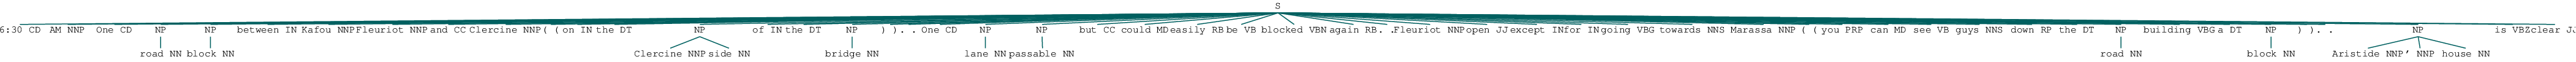

In [37]:
cp = nltk.RegexpParser(pattern)
cs = cp.parse(pos)
display(cs)

In [21]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)

[('6:30', 'CD', 'O'),
 ('AM', 'NNP', 'O'),
 ('One', 'CD', 'O'),
 ('road', 'NN', 'B-NP'),
 ('block', 'NN', 'B-NP'),
 ('between', 'IN', 'O'),
 ('Kafou', 'NNP', 'O'),
 ('Fleuriot', 'NNP', 'O'),
 ('and', 'CC', 'O'),
 ('Clercine', 'NNP', 'O'),
 ('(', '(', 'O'),
 ('on', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('Clercine', 'NNP', 'O'),
 ('side', 'NN', 'B-NP'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'B-NP'),
 ('bridge', 'NN', 'I-NP'),
 (')', ')', 'O'),
 ('.', '.', 'O'),
 ('One', 'CD', 'O'),
 ('lane', 'NN', 'B-NP'),
 ('passable', 'NN', 'B-NP'),
 ('but', 'CC', 'O'),
 ('could', 'MD', 'O'),
 ('easily', 'RB', 'O'),
 ('be', 'VB', 'O'),
 ('blocked', 'VBN', 'O'),
 ('again', 'RB', 'O'),
 ('.', '.', 'O'),
 ('Fleuriot', 'NNP', 'O'),
 ('open', 'JJ', 'O'),
 ('except', 'IN', 'O'),
 ('for', 'IN', 'O'),
 ('going', 'VBG', 'O'),
 ('towards', 'NNS', 'O'),
 ('Marassa', 'NNP', 'O'),
 ('(', '(', 'O'),
 ('you', 'PRP', 'O'),
 ('can', 'MD', 'O'),
 ('see', 'VB', 'O'),
 ('guys', 'NNS', 'O'),
 ('down', 'RP', 'O'),
 ('the', 'DT', '

In [24]:
# import os
# from IPython.display import Image, display
# from nltk.draw import TreeWidget
# from nltk.draw.util import CanvasFrame

# def jupyter_draw_nltk_tree(tree):
#     cf = CanvasFrame()
#     tc = TreeWidget(cf.canvas(), tree)
#     tc['node_font'] = 'arial 13 bold'
#     tc['leaf_font'] = 'arial 14'
#     tc['node_color'] = '#005990'
#     tc['leaf_color'] = '#3F8F57'
#     tc['line_color'] = '#175252'
#     cf.add_widget(tc, 10, 10)
#     cf.print_to_file('tmp_tree_output.ps')
#     cf.destroy()
#     os.system('convert tmp_tree_output.ps tmp_tree_output.png')
#     display(Image(filename='tmp_tree_output.png'))
#     os.system('rm tmp_tree_output.ps tmp_tree_output.png')

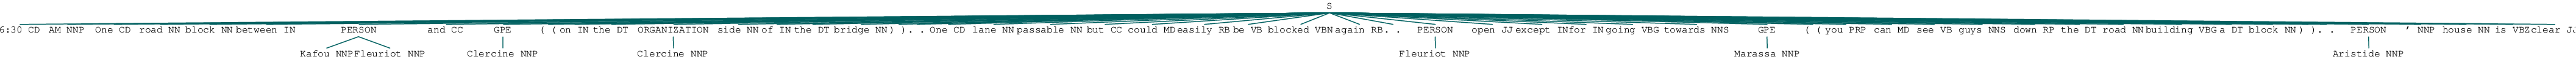

In [25]:
ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(ex)))
display(ne_tree)
# jupyter_draw_nltk_tree(ne_tree)

## Location Extraction Attempt (NER) #2

Let's look at word frequencies and see if there is anything noteworthy

In [38]:
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [39]:
report_content.sample(5)

496     Correction / Evènement rapporté à 11 am Rue F...
162     6h50 : barricades tenues sur John Brown à hau...
315     ▪14:56-> La foule qui etait dispersée commenc...
355     Sporadic incidents of problems (rock throwing...
485                           This message was deleted\n
Name: content, dtype: object

In [40]:
# Convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer()
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [41]:
vectors = vectorizer.fit_transform(iter(report_content.values)).todense()
vectors.shape

(399, 2139)

In [42]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape, vocab[300:400]

((2139,), array(['archaai', 'archaie', 'are', 'area', 'areas', 'argument',
        'aristide', 'armed', 'armes', 'armés', 'arnel', 'around',
        'arrestation', 'arrive', 'arrived', 'arrivent', 'arriving',
        'arrivés', 'arrêter', 'art', 'artibonite', 'as', 'assassiné',
        'assis', 'assistance', 'assisté', 'assistée', 'assurez', 'at',
        'atake', 'atm', 'attacked', 'attacking', 'attempt', 'attendent',
        'attendez', 'attention', 'attribué', 'attroupement', 'au', 'aucun',
        'aucune', 'aujourd', 'aussi', 'auto', 'autobus', 'automatiques',
        'automeca', 'automobilistes', 'autoplaza', 'autoroute', 'autre',
        'autres', 'aux', 'av', 'avait', 'avant', 'ave', 'avec', 'avenue',
        'avenues', 'aviation', 'avoid', 'avoided', 'avèk', 'axe', 'axes',
        'ayewopò', 'ayopo', 'aéoport', 'aéroport', 'bacha', 'back', 'bal',
        'bande', 'bandit', 'bandits', 'bank', 'baptise', 'baricade',
        'barikad', 'barrage', 'barrages', 'barricade', 'barrica

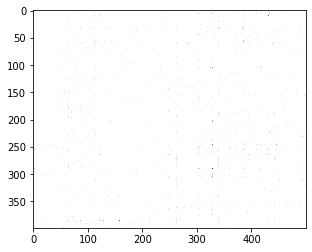

In [43]:
plt.imshow(vectors[:, :500], cmap='binary')

### SVD

Vectors is 399 x 2139 (documents x words)

In [46]:
vectors.shape

(399, 2139)

In [66]:
%time U, s, Vh = linalg.svd(vectors.T, full_matrices=False)

CPU times: user 366 ms, sys: 59.7 ms, total: 426 ms
Wall time: 138 ms


In [67]:
print(U.shape, s.shape, Vh.shape)

(2139, 399) (399,) (399, 399)


In [68]:
S = np.diag(s)

In [71]:
# Sanity check
reconst = U @ S @ Vh
np.allclose(vectors.T, reconst)

True

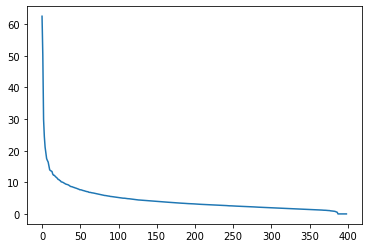

In [72]:
plt.plot(s)

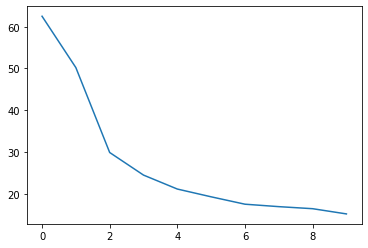

In [73]:
plt.plot(s[:10])

**U** is the 

In [74]:
# Inspect the first k singular vectors
k = 6
mat_approx = U[:, :k] @ S[:k, :k] @ Vh[:k, :]
print(mat_approx.shape)

(2139, 399)


In [75]:
Vh.shape

(399, 399)

In [76]:
temp = np.argsort(Vh[0])
temp.shape, temp

((399,),
 array([368,  13,  22, 146, 138, 396, 393, 292, 276, 277, 369, 336,  36,
         37,  81, 136,  28, 346, 215, 254, 352,  20, 116,  83, 110, 240,
         67,  40,  87, 232,  52,  26,  63, 122, 338,  49,  35, 351,  86,
        181, 134,   4,  95,  94, 344,  41,  29, 233,  48, 293,  43, 350,
         15, 119, 343, 159,  90,  23,   0, 354, 133, 257, 358, 140,  16,
         45, 241, 245, 291, 320,  62, 151, 380, 376, 263, 345, 311,  64,
        220, 124,  84, 175, 260, 332, 155,  65, 180, 259,  31,  27, 100,
        101,  53, 353, 147, 372, 362, 216,   1, 178, 296,  42, 165, 261,
        184, 262, 209, 226, 207, 386,  50, 328,  92, 164,  25, 373, 310,
        371, 363,   8, 158,  97, 171, 111, 103,  93, 237, 125, 382, 118,
        247, 182, 170, 106, 289, 335, 193, 128, 266, 250, 318, 316,  80,
         19, 104, 300,  38,  79, 323,  54,  70, 162, 348, 357, 130, 186,
        309, 211, 365, 355, 176, 384, 283,  68, 315, 163, 388, 268, 378,
         51,   9, 374, 143, 197, 347, 271,

In [82]:
words = []
for i in temp:
    words.append(vocab[i])
words

['ayopo',
 '0539',
 '0573',
 '45',
 '41',
 'beaucoup',
 'bcp',
 'apres',
 'anndan',
 'annoncent',
 'aéoport',
 'attention',
 '0634',
 '0635',
 '1715',
 '40',
 '0611',
 'automatiques',
 'accidentée',
 'aller',
 'autres',
 '0555',
 '30pm',
 '18',
 '29',
 'aggressifs',
 '12',
 '0641',
 '1ere',
 'aeropeort',
 '0716hrs',
 '0608',
 '105',
 '32am',
 'attroupement',
 '0702',
 '0632',
 'autre',
 '19',
 '66',
 '3e',
 '04',
 '2020',
 '202',
 'auto',
 '0643',
 '0613',
 'aeroport',
 '0700',
 'après',
 '0648',
 'autoroute',
 '0541',
 '3122',
 'aussi',
 '50am',
 '20',
 '06',
 '00',
 'av',
 '3b',
 'along',
 'avec',
 '42am',
 '0545',
 '0654',
 'aggressive',
 'aid',
 'approximative',
 'artibonite',
 '103',
 '48am',
 'barikad',
 'bandits',
 'amb',
 'autobus',
 'around',
 '10nov2019',
 'accédants',
 '3366',
 '18h30',
 '59',
 'alternative',
 'attacking',
 '50',
 '11',
 '65',
 'alternate',
 '0615',
 '0610',
 '22',
 '2229',
 '0720',
 'aux',
 '45am',
 'back',
 'avoid',
 'accidentés',
 '01',
 '60',
 'arbre',
 

In [65]:
# sort each row of Vh
for row in Vh[:3]:
    words = []
    for indx in np.argsort(row):
        words.append(vocab[indx])
    print(words)

['de', 'la', 'route', 'delmas', 'et', 'carrefour', 'les', 'at', 'restriction', 'to', 'sur', 'the', 'des', 'au', 'en', 'hrs', 'and', 'du', 'of', 'barricades', 'from', 'zone', 'on', 'le', 'sont', 'niveau', 'nouveau', 'est', 'are', 'nationale', 'clear', 'pneus', 'fleuriot', '15', 'road', 'blocage', 'blocages', 'enflammés', 'am', 'rue', 'tabarre', 'situation', 'in', 'is', 'all', 'aéroport', 'pas', 'entre', 'un', 'police', 'area', 'ouest', 'ville', 'pv', 'pour', 'restricted', 'marassa', '02', '11', 'qui', 'par', 'ok', 'roads', 'dans', 'région', 'goave', '30', '01', 'zones', '33', 'croix', 'passable', 'vert', 'place', 'vers', 'roadblocks', '12', 'octobre', 'une', 'bloquée', 'petit', 'sécuritaire', '19', '31', 'torcel', 'bouquets', 'tirs', '2019', 'down', 'bloqué', 'martissant', '27', 'canapé', 'blvd', 'que', 'national', 'tous', 'airport', 'roadblock', 'nazon', 'mars', 'main', 'cabaret', 'barricade', 'port', '50', 'pm', 'routes', 'academy', 'bas', 'prince', 'aux', 'drouillard', 'frères', 'obs

In [79]:
num_top_words = k
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [80]:
show_topics(Vh[:6])

['alliance 0532 0619 armed armes ambassade',
 'appel armed ailleurs 0518 8000 26',
 'armed 03 _up_ 0619 airport ailleurs',
 'alliance 0532 ailleurs armed 0518 areas',
 '0619 0532 appel _up_ 08 101',
 'ambassade actifs advanced arrestation 203 armes']

In [508]:
show_topics(Vh[:50])

['max 150 beside carrefoure 0716hrs eva lady violance against confrontations',
 'at the to and of hrs from on road in',
 'delmas hrs clear to from all is down main rue',
 'de delmas au niveau am est zone des pas pv',
 'est la is et am to 15 un from le',
 'de au the niveau en in area embassy is pm',
 'to 509 la ok 33 19 and 37 this changed',
 'the is carrefour ok road de 15 fleuriot embassy aristide',
 'au 11 delmas the 19 niveau 509 12 is 37',
 'carrefour 509 12 19 11 37 changed to de am',
 'and au hrs are embassy of et area niveau route',
 'at this au time pneus enflammés et pv and niveau',
 'la niveau au 15 ok route barricades and pour are',
 'et sur des pneus pv du of in enflammés the',
 'des zone carrefour difficile sur pv dans axe to embassy',
 'au to on is vert clear national des niveau airport',
 'les au du roadblock rue ville sont at roadblocks et',
 'sur des on 10 to pneus enflammés am airport road',
 'le et du to 1602 road bloqué pm est 27',
 'les du 11 2019 are au bloqué son

### PCA